# Helpers

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [2]:
metrics_files = [
    glob.glob('acl-arc/1 - Instruct Q8/*/metrics/*.csv'),
    glob.glob('acl-arc/1 - Instruct Q8/zero-shot/metrics/*.csv'),
    glob.glob('acl-arc/1 - Instruct Q8/one-shot/metrics/*.csv'),
    glob.glob('acl-arc/1 - Instruct Q8/few-shot/metrics/*.csv'),
    glob.glob('acl-arc/1 - Instruct Q8/many-shot/metrics/*.csv')
]

In [3]:
def metrics_files_processing(metrics_files, flag):
    data = []
    for m_file in metrics_files:
        # Parse filename to extract metadata
        m_filename = m_file.split('/')[-1]
        parts = m_filename.split('_')

        dataset = parts[2]
        method = parts[3]
        system_prompt = parts[4][2:]  # Remove "SP" prefix
        query_template = parts[5][2:]  # Remove "QT" prefix
        examples_method = parts[6][2:] if "EM" in parts[6] else None  # Handle zero-shot case
        temperature = float(parts[7][1:]) if "T" in parts[7] else float(parts[6][1:]) # Remove "T" prefix

        # Load CSV and add metadata columns
        df = pd.read_csv(m_file)
        df['Dataset'] = dataset
        df['Method'] = method
        df['System_Prompt'] = system_prompt
        df['Query_Template'] = query_template
        df['Examples_Method'] = examples_method
        df['Temperature'] = temperature
        df['Filename'] = m_filename.split("_metrics_")[-1]

        if flag == 'best':
            # in each dataframe, find the best performing model and set the "best performing" column to 1
            df['Best_Performing'] = 0
            best_f1 = df['F1-Score'].max()
            best_models = df[df['F1-Score'] == best_f1]
            if len(best_models) > 1:
                best_accuracy = best_models['Accuracy'].max()
                df.loc[(df['F1-Score'] == best_f1) & (df['Accuracy'] == best_accuracy), 'Best_Performing'] = 1
            else:
                df.loc[df['F1-Score'] == best_f1, 'Best_Performing'] = 1
        elif flag == 'rank':
            # Sort models by F1-score in descending order
            df = df.sort_values(by=['F1-Score', 'Accuracy'], ascending=[False, False]).reset_index(drop=True)
            # Assign ranking scores (1 for the top model, 1/2 for the second, etc.)
            df['Ranking_Score'] = pd.Series(1 / (df.index + 1)).round(3)
        else:
            raise ValueError(f"Invalid flag: {flag}")

        data.append(df)

    # Concatenate all data
    all_metrics = pd.concat(data, ignore_index=True)
    print(len(all_metrics))
    if flag == 'best':
        all_metrics = all_metrics.sort_values(by=['F1-Score'], ascending=False).reset_index().drop(columns=['index'])
        all_metrics.index += 1
    elif flag == 'rank':
        # Sum the ranking scores for each model across all configurations
        all_metrics = all_metrics.groupby('Model')['Ranking_Score'].sum().reset_index()

        # Sort models by their total ranking score
        all_metrics = all_metrics.sort_values(by='Ranking_Score', ascending=False).reset_index().drop(columns=['index'])
        all_metrics.index += 1
    else:
        raise ValueError(f"Invalid flag: {flag}")

    return all_metrics


def norm_rank(model_scores):
    # Normalize the total ranking scores using Min-Max normalization
    min_score = model_scores['Ranking_Score'].min()
    max_score = model_scores['Ranking_Score'].max()

    model_scores['Normalized_Score'] = (model_scores['Ranking_Score'] - min_score) / (max_score - min_score)

    return model_scores


def plot_rank(model_scores, mode='single', score='rank'):
    if mode == 'single':
        if score == 'rank':
            score_column = [col for col in model_scores.columns if "Ranking_Score" in col]
            score_label = "Rank"
        elif score == 'norm':
            score_column = [col for col in model_scores.columns if "Normalized_Score" in col]
            score_label = "Normalized Rank"

        df_plot = model_scores[["Model"] + score_column].copy()

        df_plot.set_index("Model", inplace=True)
        df_plot.plot(kind='bar', figsize=(10, 6), width=0.8)
        # plt.figure(figsize=(10, 6))
        # plt.barh(model_scores['Model'], score_column, color='skyblue')
        plt.xlabel('Model')
        plt.ylabel(score_label)
        plt.title(f'{score_label}ed Performance by Model')
        # plt.gca().invert_yaxis()
        plt.xticks(rotation=45, ha='right')
        plt.legend().remove()
        plt.tight_layout()
        plt.show()
    elif mode == 'multi':
        if score == 'rank':
            score_columns = [col for col in model_scores.columns if "Ranking_Score" in col]
            score_label = "Rank"
        elif score == 'norm':
            score_columns = [col for col in model_scores.columns if "Normalized_Score" in col]
            score_label = "Normalized Rank"

        # Create a copy of the dataframe with only the relevant columns
        df_plot = model_scores[["Model"] + score_columns].copy()

        # Rename columns to show only the last part after splitting by '_'
        df_plot.rename(columns={col: col.split("_")[-1] for col in score_columns}, inplace=True)
    
        # Set the model names as index
        df_plot.set_index("Model", inplace=True)
        
        # Plot
        df_plot.plot(kind='bar', figsize=(10, 6), width=0.8)
        plt.title(f"{score_label}ed Performance by Model")
        plt.xlabel("Model")
        plt.ylabel(score_label)
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()


def merge_rank_dataframes(dataframes, labels, sort=None):
    merged_df = dataframes[0].copy()
    
    merged_df = merged_df.rename(columns={
        "Ranking_Score": f"Ranking_Score_{labels[0]}",
        "Normalized_Score": f"Normalized_Score_{labels[0]}"
    })

    for i in range(1, len(dataframes)):
        df = dataframes[i].copy()
        df = df.rename(columns={
            "Ranking_Score": f"Ranking_Score_{labels[i]}",
            "Normalized_Score": f"Normalized_Score_{labels[i]}"
        })
        merged_df = merged_df.merge(df, on="Model", how="outer")

    if sort is not None:
        merged_df['Model'] = merged_df['Model'].astype("category")
        merged_df['Model'] = merged_df['Model'].cat.set_categories(sort, ordered=True)

        merged_df = merged_df.sort_values("Model").reset_index(drop=True)
        merged_df.index += 1

    return merged_df


def parameter_distributions(metrics, subset, label):
    topK_counts = metrics[metrics['Top'] == 1].value_counts(subset=[subset])
    topK_percent = metrics[metrics['Top'] == 1].value_counts(subset=[subset], normalize=True)

    df_vc = pd.DataFrame({"count": topK_counts, "%": topK_percent*100}).reset_index()
    df_vc.columns = [label, 'Count', 'Percent']
    df_vc.index += 1

    return df_vc

# Top 50 configurations (sort: F1-score)

In [4]:
metrics_total = metrics_files_processing(metrics_files[0], flag="best")

display(metrics_total.drop(columns=['Filename']).head(50))
metrics_total.drop(columns=['Best_Performing', 'Filename', 'Dataset']).to_csv('aclarc_best_performing_models.csv', index=True)

1824


,Model,Precision,Recall,F1-Score,Accuracy,Dataset,Method,System_Prompt,Query_Template,Examples_Method,Temperature,Best_Performing
1,QWEN2.5_14B,0.6702,0.6637,0.6368,0.6619,acl-arc,many-shot,2,2,1,0.2,1
2,QWEN2.5_14B,0.6540,0.6637,0.6302,0.6619,acl-arc,many-shot,2,2,1,0.0,1
3,QWEN2.5_14B,0.6304,0.6687,0.6286,0.6763,acl-arc,few-shot,1,2,2,0.5,1
4,QWEN2.5_14B,0.6277,0.6637,0.6239,0.6619,acl-arc,few-shot,2,2,1,0.2,1
5,QWEN2.5_14B,0.6377,0.6681,0.6228,0.6619,acl-arc,few-shot,2,2,2,1.0,1
6,QWEN2.5_14B,0.6164,0.6644,0.6222,0.6763,acl-arc,few-shot,1,2,2,0.2,1
7,QWEN2.5_14B,0.6164,0.6644,0.6222,0.6763,acl-arc,few-shot,1,2,2,0.0,1
8,QWEN2.5_14B,0.6310,0.6657,0.6215,0.6547,acl-arc,few-shot,2,2,2,0.5,1
9,QWEN2.5_14B,0.6500,0.6354,0.6201,0.6691,acl-arc,few-shot,1,1,2,0.5,1
10,QWEN2.5_14B,0.6279,0.6634,0.6188,0.6475,acl-arc,few-shot,2,2,2,0.0,1


# Best Performing Models per Configuration

In [5]:
# display only the best performing models
best_performing = metrics_total[metrics_total['Best_Performing'] == 1]

# Group by 'Model' and 'Method' and count occurrences for each combination
method_counts = best_performing.groupby(['Model', 'Method']).size().unstack(fill_value=0)
method_counts = method_counts[['zero-shot', 'one-shot', 'few-shot', 'many-shot']]

# create a new dataframe with two columns: The model name, and the count of how many times it was the best performing model
best_performing_counts = best_performing['Model'].value_counts().reset_index()
best_performing_counts.columns = ['Model', 'Best Performing Count']
best_performing_counts = best_performing_counts.merge(method_counts, on='Model', how='left')
best_performing_counts.index += 1
display(best_performing_counts)

,Model,Best Performing Count,zero-shot,one-shot,few-shot,many-shot
1,QWEN2.5_14B,129,19,22,40,48
2,GEMMA2-27B,28,0,21,7,0
3,GEMMA2-9B,11,5,5,1,0


### Best Qwen 2.5 14B

In [6]:
best_performing_qwen = best_performing[best_performing['Model'] == 'QWEN2.5_14B'].sort_values(by='F1-Score', ascending=False).reset_index().drop(columns=['Model', 'Dataset', 'Best_Performing', 'index'])
best_performing_qwen.index += 1

display(best_performing_qwen)

,Precision,Recall,F1-Score,Accuracy,Method,System_Prompt,Query_Template,Examples_Method,Temperature,Filename
1,0.6702,0.6637,0.6368,0.6619,many-shot,2,2,1,0.2,acl-arc_many-shot_SP2_QT2_EM1_T0.2_Q8.csv
2,0.6540,0.6637,0.6302,0.6619,many-shot,2,2,1,0.0,acl-arc_many-shot_SP2_QT2_EM1_T0.0_Q8.csv
3,0.6304,0.6687,0.6286,0.6763,few-shot,1,2,2,0.5,acl-arc_few-shot_SP1_QT2_EM2_T0.5_Q8.csv
4,0.6277,0.6637,0.6239,0.6619,few-shot,2,2,1,0.2,acl-arc_few-shot_SP2_QT2_EM1_T0.2_Q8.csv
5,0.6377,0.6681,0.6228,0.6619,few-shot,2,2,2,1.0,acl-arc_few-shot_SP2_QT2_EM2_T1.0_Q8.csv
6,0.6164,0.6644,0.6222,0.6763,few-shot,1,2,2,0.2,acl-arc_few-shot_SP1_QT2_EM2_T0.2_Q8.csv
7,0.6164,0.6644,0.6222,0.6763,few-shot,1,2,2,0.0,acl-arc_few-shot_SP1_QT2_EM2_T0.0_Q8.csv
8,0.6310,0.6657,0.6215,0.6547,few-shot,2,2,2,0.5,acl-arc_few-shot_SP2_QT2_EM2_T0.5_Q8.csv
9,0.6500,0.6354,0.6201,0.6691,few-shot,1,1,2,0.5,acl-arc_few-shot_SP1_QT1_EM2_T0.5_Q8.csv
10,0.6279,0.6634,0.6188,0.6475,few-shot,2,2,2,0.0,acl-arc_few-shot_SP2_QT2_EM2_T0.0_Q8.csv


### Best GEMMA 2 - 27B

In [7]:
best_performing_gemma2_27b = best_performing[best_performing['Model'] == 'GEMMA2-27B'].sort_values(by='F1-Score', ascending=False).reset_index().drop(columns=['Model', 'Dataset', 'Best_Performing', 'index'])
best_performing_gemma2_27b.index += 1

display(best_performing_gemma2_27b)

,Precision,Recall,F1-Score,Accuracy,Method,System_Prompt,Query_Template,Examples_Method,Temperature,Filename
1,0.6051,0.6352,0.5895,0.5971,few-shot,3,1,2,1.0,acl-arc_few-shot_SP3_QT1_EM2_T1.0_Q8.csv
2,0.6020,0.6356,0.5885,0.6115,few-shot,3,1,2,0.0,acl-arc_few-shot_SP3_QT1_EM2_T0.0_Q8.csv
3,0.6020,0.6356,0.5885,0.6115,few-shot,3,1,2,0.2,acl-arc_few-shot_SP3_QT1_EM2_T0.2_Q8.csv
4,0.5750,0.5811,0.5655,0.6043,one-shot,3,2,1,0.0,acl-arc_one-shot_SP3_QT2_EM1_T0.0_Q8.csv
5,0.5750,0.5811,0.5655,0.6043,one-shot,3,2,1,0.2,acl-arc_one-shot_SP3_QT2_EM1_T0.2_Q8.csv
6,0.6117,0.5632,0.5653,0.6259,few-shot,1,1,2,1.0,acl-arc_few-shot_SP1_QT1_EM2_T1.0_Q8.csv
7,0.5735,0.5869,0.5630,0.5971,one-shot,3,2,1,0.5,acl-arc_one-shot_SP3_QT2_EM1_T0.5_Q8.csv
8,0.5761,0.5522,0.5561,0.6115,one-shot,2,2,2,0.0,acl-arc_one-shot_SP2_QT2_EM2_T0.0_Q8.csv
9,0.5729,0.5825,0.5556,0.5971,one-shot,3,1,1,0.0,acl-arc_one-shot_SP3_QT1_EM1_T0.0_Q8.csv
10,0.5716,0.5825,0.5553,0.5971,one-shot,3,1,1,0.2,acl-arc_one-shot_SP3_QT1_EM1_T0.2_Q8.csv


### Best GEMMA 2 - 9B

In [8]:
best_performing_gemma2_27b = best_performing[best_performing['Model'] == 'GEMMA2-9B'].sort_values(by='F1-Score', ascending=False).reset_index().drop(columns=['Model', 'Dataset', 'Best_Performing', 'index'])
best_performing_gemma2_27b.index += 1

display(best_performing_gemma2_27b)

,Precision,Recall,F1-Score,Accuracy,Method,System_Prompt,Query_Template,Examples_Method,Temperature,Filename
1,0.5636,0.5179,0.5322,0.5827,one-shot,3,1,2,1.0,acl-arc_one-shot_SP3_QT1_EM2_T1.0_Q8.csv
2,0.6496,0.5202,0.5235,0.6259,few-shot,2,1,1,0.0,acl-arc_few-shot_SP2_QT1_EM1_T0.0_Q8.csv
3,0.5620,0.4898,0.5079,0.6187,zero-shot,1,2,None,0.5,acl-arc_zero-shot_SP1_QT2_T0.5_Q8.csv
4,0.5719,0.4902,0.4801,0.5899,one-shot,2,1,1,0.2,acl-arc_one-shot_SP2_QT1_EM1_T0.2_Q8.csv
5,0.5665,0.4902,0.4789,0.5899,one-shot,2,1,1,0.0,acl-arc_one-shot_SP2_QT1_EM1_T0.0_Q8.csv
6,0.5676,0.4861,0.4729,0.5899,one-shot,2,1,1,0.5,acl-arc_one-shot_SP2_QT1_EM1_T0.5_Q8.csv
7,0.5566,0.5074,0.4703,0.5612,one-shot,2,1,1,1.0,acl-arc_one-shot_SP2_QT1_EM1_T1.0_Q8.csv
8,0.5521,0.4498,0.4681,0.6043,zero-shot,1,2,None,1.0,acl-arc_zero-shot_SP1_QT2_T1.0_Q8.csv
9,0.5417,0.4329,0.4538,0.5899,zero-shot,2,2,None,0.2,acl-arc_zero-shot_SP2_QT2_T0.2_Q8.csv
10,0.5417,0.4329,0.4530,0.5899,zero-shot,2,2,None,0.0,acl-arc_zero-shot_SP2_QT2_T0.0_Q8.csv


# Ranked Model Performance

### 1. Ranking Models in Each Configuration

For a given experimental configuration $c$ , let:

* $M = m_1, m_2, \dots, m_n$  be the set of models evaluated in configuration $c$.
* $\text{F1}(m_i, c)$ be the F1-score of model $m_i$ in configuration $c$.

Sort the models in $M$ by their F1-scores in descending order:

* $\text{F1}(m_{1}, c) \geq \text{F1}(m_{2}, c) \geq \dots \geq \text{F1}(m_{n}, c)$

where $m_{k}$  is the  $k$-th ranked model in configuration $c$.

### 2. Assigning Scores Based on Rank

For each model $m_{k}$  in configuration $c$, assign a score $S(m_{k}, c)$ based on its rank $k$:

* $S(m_{k}, c) = \frac{1}{k}$

### 3. Aggregating Scores Across Configurations

Let $C$ be the set of all configurations. For each model $m$, calculate the total score $Rank(m)$ by summing its scores across all configurations $c \in C$:

* $Rank(m) = \sum_{c \in C} S(m, c)$

where $S(m, c)$ is the score assigned to model $m$ in configuration $c$. If $m$ does not appear in configuration $c$, then $S(m, c) = 0$.



## All Methods

In [9]:
metrics_rank = metrics_files_processing(metrics_files[0], flag="rank")
display(metrics_rank)
metrics_rank.to_csv('acl-arc_ranked_models.csv', index=True)

1824


,Model,Ranking_Score
1,QWEN2.5_14B,146.496
2,GEMMA2-27B,62.973
3,GEMMA2-9B,55.318
4,QWEN2,41.496
5,LLAMA3.1,40.844
6,PHI3.5_MINI,30.470
7,MISTRAL_NEMO,30.285
8,LLAMA3.2_3B,23.984
9,PHI3_MEDIUM,21.269
10,LLAMA3.2_1B,16.796


### Plot

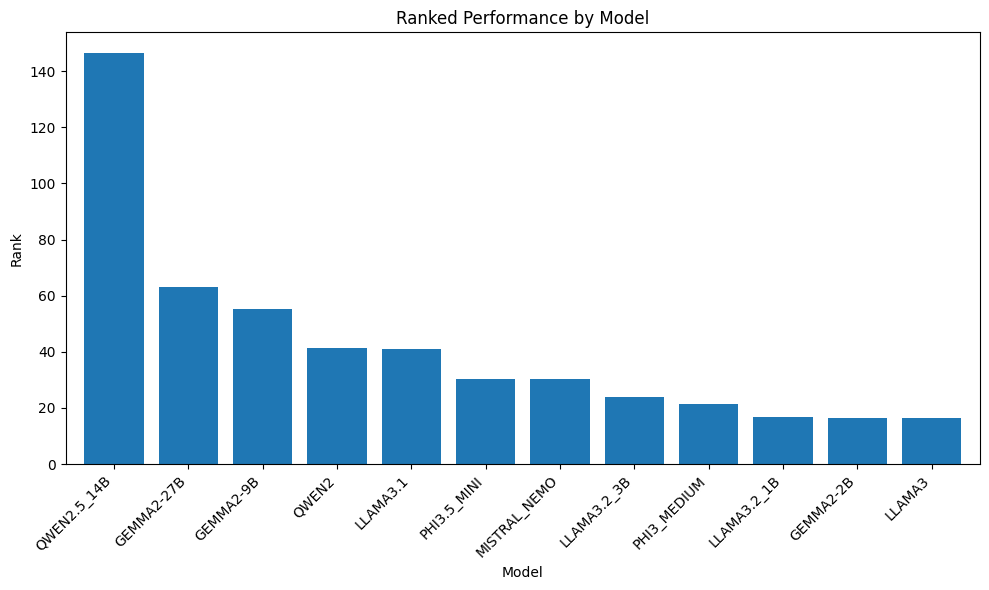

In [10]:
metrics_rank_norm = norm_rank(metrics_rank)
plot_rank(metrics_rank_norm, score='rank')

## Zero-Shot

In [11]:
metrics_rank_zero = metrics_files_processing(metrics_files[1], flag="rank")
display(metrics_rank_zero)

288


,Model,Ranking_Score
1,QWEN2.5_14B,21.500
2,GEMMA2-9B,13.498
3,GEMMA2-27B,7.283
4,QWEN2,5.251
5,LLAMA3,4.976
6,LLAMA3.1,4.347
7,GEMMA2-2B,4.276
8,PHI3.5_MINI,3.753
9,MISTRAL_NEMO,2.835
10,LLAMA3.2_3B,2.577


### Plot

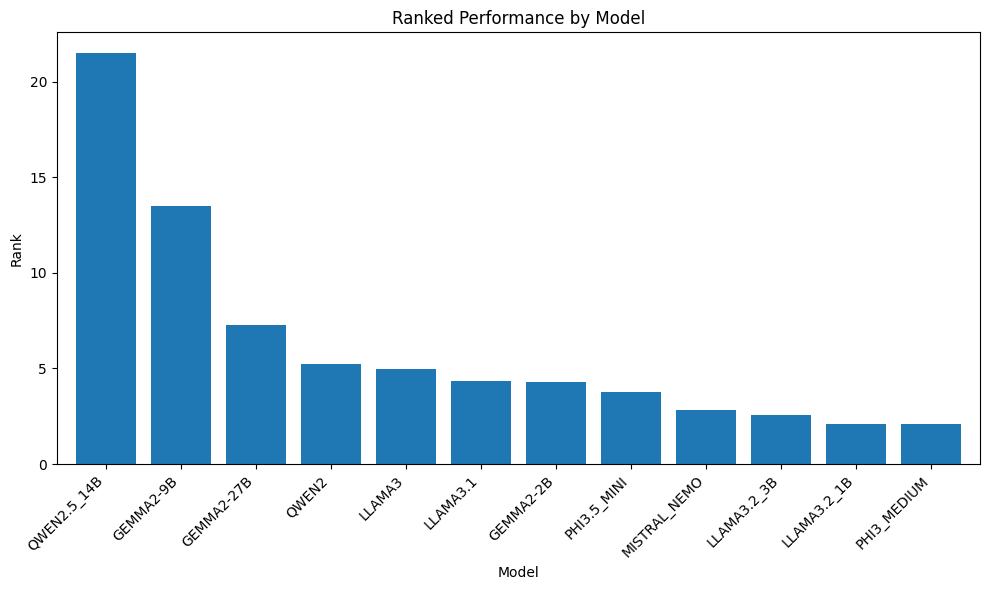

In [12]:
metrics_rank_zero_norm = norm_rank(metrics_rank_zero)
plot_rank(metrics_rank_zero_norm, score='rank')

## One-Shot

In [13]:
metrics_rank_one = metrics_files_processing(metrics_files[2], flag="rank")
display(metrics_rank_one)

576


,Model,Ranking_Score
1,QWEN2.5_14B,33.163
2,GEMMA2-27B,32.997
3,GEMMA2-9B,21.409
4,LLAMA3.1,10.499
5,MISTRAL_NEMO,9.096
6,QWEN2,8.110
7,PHI3.5_MINI,6.379
8,LLAMA3.2_3B,6.029
9,LLAMA3,6.006
10,GEMMA2-2B,5.987


### Plot

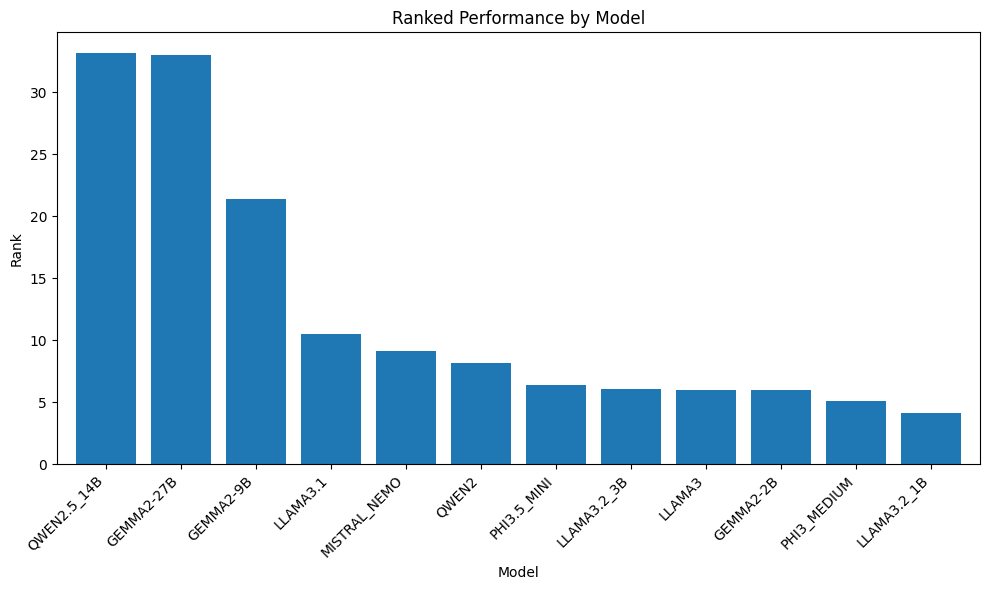

In [14]:
metrics_rank_one_norm = norm_rank(metrics_rank_one)
plot_rank(metrics_rank_one_norm, score='rank')

## Few-Shot

In [15]:
metrics_rank_few = metrics_files_processing(metrics_files[3], flag="rank")
display(metrics_rank_few)

576


,Model,Ranking_Score
1,QWEN2.5_14B,43.833
2,GEMMA2-27B,22.693
3,GEMMA2-9B,20.411
4,QWEN2,10.523
5,LLAMA3.1,9.234
6,MISTRAL_NEMO,8.421
7,PHI3.5_MINI,6.558
8,LLAMA3.2_3B,6.327
9,GEMMA2-2B,6.271
10,LLAMA3,5.377


### Plot

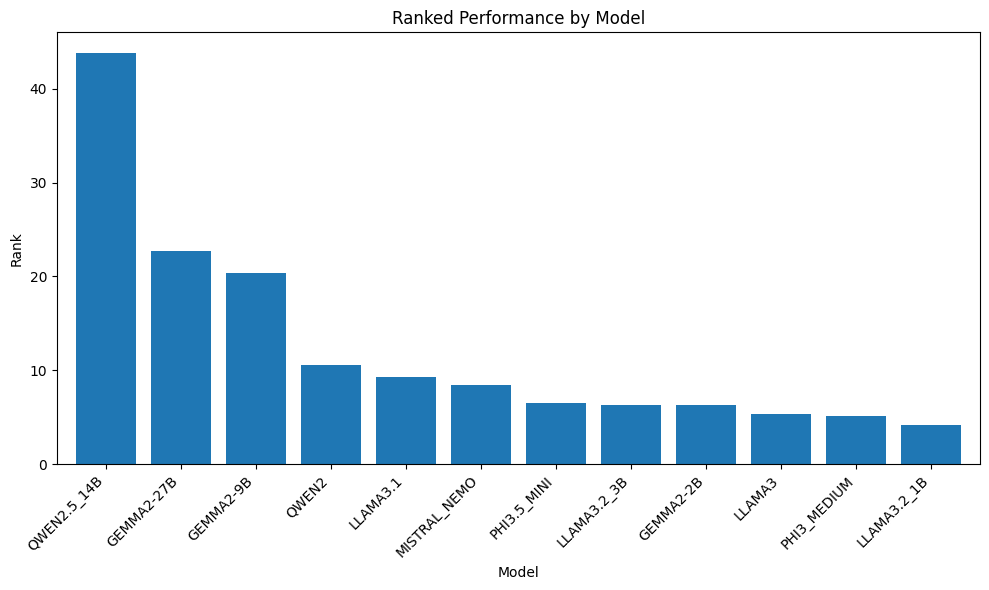

In [16]:
metrics_rank_few_norm = norm_rank(metrics_rank_few)
plot_rank(metrics_rank_few_norm, score='rank')

## Many-Shot

In [17]:
metrics_rank_many = metrics_files_processing(metrics_files[4], flag="rank")
display(metrics_rank_many)

384


,Model,Ranking_Score
1,QWEN2.5_14B,48.000
2,QWEN2,17.612
3,LLAMA3.1,16.764
4,PHI3.5_MINI,13.780
5,MISTRAL_NEMO,9.933
6,LLAMA3.2_3B,9.051
7,PHI3_MEDIUM,8.970
8,LLAMA3.2_1B,6.354


### Plot

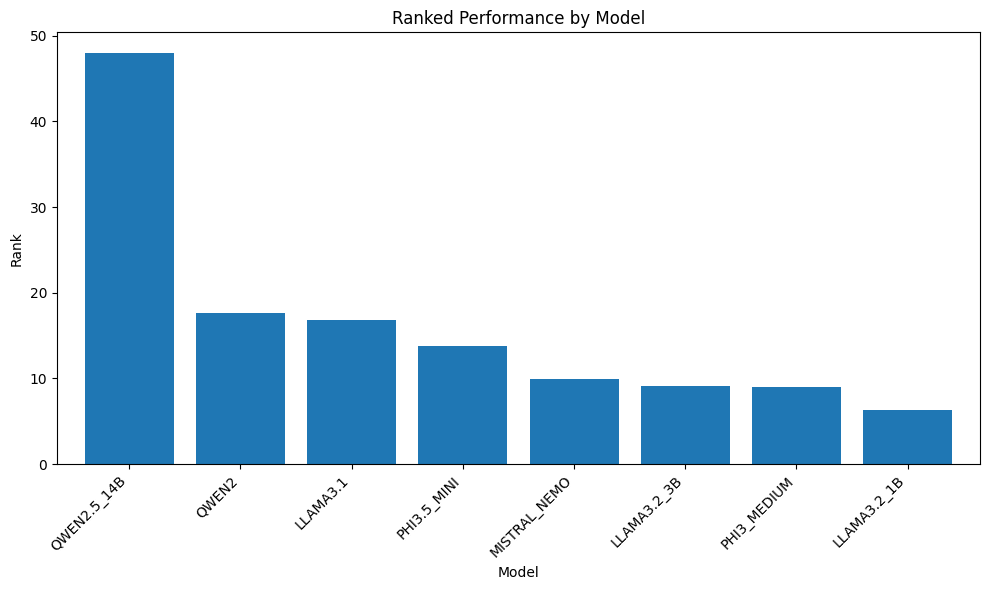

In [18]:
metrics_rank_many_norm = norm_rank(metrics_rank_many)
plot_rank(metrics_rank_many_norm, score='rank')

## Overall Shot Method Comparison

### Plot Methods Grouped

In [19]:
metrics_rank_dataframes_methods_only = [metrics_rank_zero_norm, metrics_rank_one_norm, metrics_rank_few_norm, metrics_rank_many_norm]
df_labels=['Zero-Shot', 'One-Shot', 'Few-Shot', 'Many-Shot']
model_sort = metrics_rank['Model'].tolist()

metrics_rank_dataframes_methods_only = merge_rank_dataframes(dataframes=metrics_rank_dataframes_methods_only, labels=df_labels, sort=model_sort)

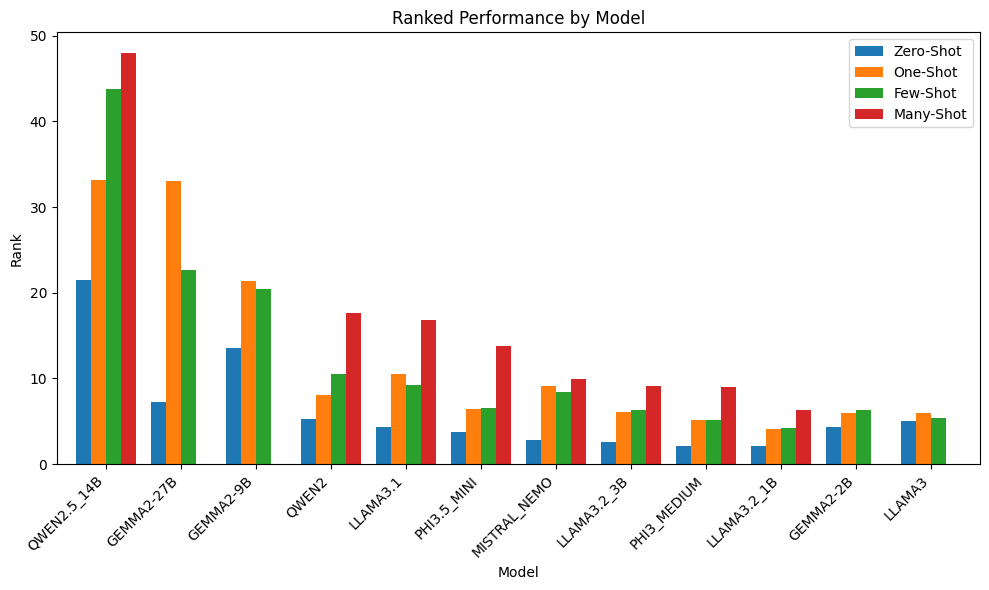

In [20]:
# plot_rank(metrics_rank_dataframes_methods_only, mode='multi', score='norm')
plot_rank(metrics_rank_dataframes_methods_only, mode='multi', score='rank')

### Plot Methods Grouped + Total

In [21]:
metrics_rank_dataframes = [metrics_rank_norm, metrics_rank_zero_norm, metrics_rank_one_norm, metrics_rank_few_norm, metrics_rank_many_norm]
df_labels=['All Methods', 'Zero-Shot', 'One-Shot', 'Few-Shot', 'Many-Shot']
metrics_rank_all = merge_rank_dataframes(dataframes=metrics_rank_dataframes, labels=df_labels)

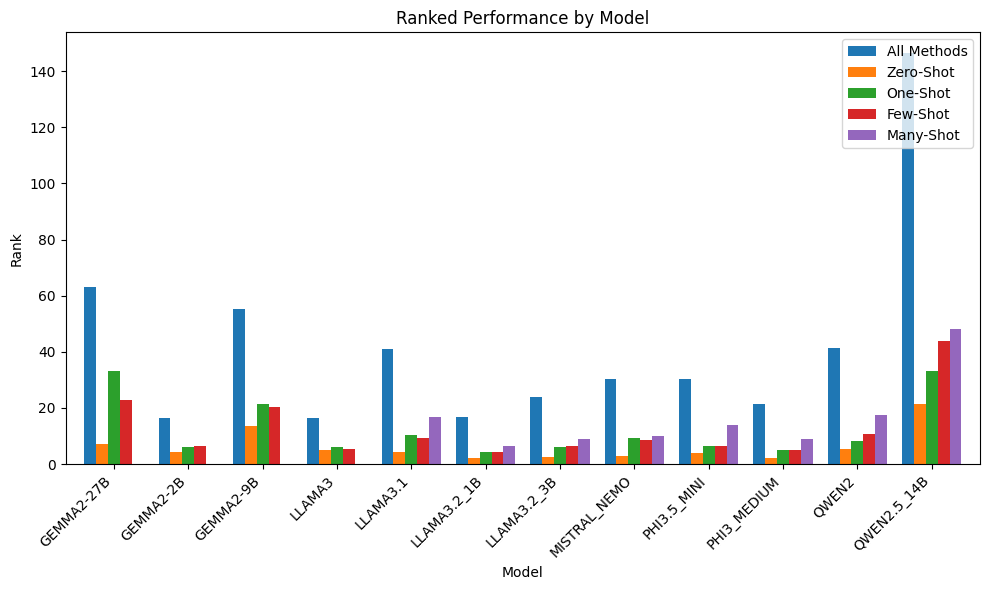

In [22]:
# plot_rank(metrics_rank_all, mode='multi', score='norm')
plot_rank(metrics_rank_all, mode='multi', score='rank')

# Generalized Parameter Analysis

In [23]:
if 'Top' in metrics_total.columns:
    metrics_total = metrics_total.drop(columns=['Top'])

# top_k = 50
# metrics_total['Top'] = metrics_total.index <= top_k  # Binary indicator for top configs

# top_quantile = 0.1
top_quantile = 0.05
metrics_total['Top'] = metrics_total['F1-Score'] >= metrics_total['F1-Score'].quantile(1 - top_quantile)

## 1. Prompting Method

Check the prompting method distribution of the top-K configurations to identify if there is an optimal one.

In [24]:
method_vc = parameter_distributions(metrics_total, 'Method', 'Method')
display(method_vc)

,Method,Count,Percent
1,few-shot,55,61.111111
2,many-shot,21,23.333333
3,one-shot,14,15.555556


## 2. Temperature

Check the temperature distribution of the top-K configurations to identify if there is an optimal one.

In [25]:
temp_vc = parameter_distributions(metrics_total, 'Temperature', 'Temperature')
display(temp_vc)

,Temperature,Count,Percent
1,0.0,23,25.555556
2,1.0,23,25.555556
3,0.2,22,24.444444
4,0.5,22,24.444444


## 3. System Prompt

Check the System Prompt distribution of the top-K configurations to identify if there is an optimal one.

In [26]:
sp_vc = parameter_distributions(metrics_total, 'System_Prompt', 'System Prompt')
display(sp_vc)

,System Prompt,Count,Percent
1,3,38,42.222222
2,1,28,31.111111
3,2,24,26.666667


## 4. Query Template

Check the Query Template distribution of the top-K configurations to identify if there is an optimal one.

In [27]:
qt_vc = parameter_distributions(metrics_total, 'Query_Template', 'Query Template')
display(qt_vc)

,Query Template,Count,Percent
1,2,58,64.444444
2,1,32,35.555556


## 5. Examples Method

Check the Examples Method distribution of the top-K configurations to identify if there is an optimal one.

In [28]:
em_vc = parameter_distributions(metrics_total, 'Examples_Method', 'Examples Method')
display(em_vc)

,Examples Method,Count,Percent
1,2,59,65.555556
2,1,31,34.444444


## 5. Chi-Square Test of Independence

In [29]:
for col in ['Method', 'Temperature', 'System_Prompt', 'Query_Template', 'Examples_Method']:
    contingency = pd.crosstab(metrics_total[col], metrics_total['Top'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"Chi-Square test for {col}: chi2={chi2}, p={p}")

Chi-Square test for Method: chi2=49.02550301166218, p=1.2882511340649728e-10
Chi-Square test for Temperature: chi2=0.04675124951941561, p=0.9973489028683749
Chi-Square test for System_Prompt: chi2=3.6465974625144173, p=0.16149215210823353
Chi-Square test for Query_Template: chi2=7.304882737408689, p=0.006876748445994545
Chi-Square test for Examples_Method: chi2=8.60414937759336, p=0.0033539797971747208
